In [1]:
import arbor as A
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Part I: Single Cell Models

## Helper functions

**NOTE** You _can_ look at these, if you want, but they contain mainly unimportant details.

Use matplotlib to draw morphologies in 3d

In [51]:
def plot_morphology(mrf, *, fg=None):
    tree = mrf.to_segment_tree()
    colors = sns.color_palette('Set1')
    if not fg:
        fg = plt.figure(figsize=(10, 10))
    ax = fg.add_subplot(projection='3d')
    for seg in tree.segments:
        x0 = seg.prox.x
        x1 = seg.dist.x
        y0 = seg.prox.y
        y1 = seg.dist.y
        z0 = seg.prox.z
        z1 = seg.dist.z
        r0 = seg.prox.radius
        r1 = seg.dist.radius
        tag = seg.tag
    
        ax.plot(xs=[x0, x1], 
                ys=[y0, y1], 
                zs=[z0, z1], 
                color=colors[tag], 
                lw=(r0 + r1)) # average diameter from radius
    ax.set_xlabel(r'x $(\mu m)$')
    ax.set_ylabel(r'y $(\mu m)$')
    ax.set_zlabel(r'z $(\mu m)$')
    return fg, ax

Run a single cell model defined by morphology and decor and plot the membrane potential

In [186]:
def run_single_cell(mrf, dec):
    cell = A.cable_cell(mrf, dec)
    sim = A.single_cell_model(cell)
    sim.probe('voltage', where='(location 0 0.5)', frequency=10)
    sim.run(100)
    trace = sim.traces[0]

    fg, ax = plt.subplots()
    ax.plot(trace.time, trace.value)
    ax.set_ylim(-80, 40)
    ax.set_xlim(0, 100)
    ax.set_ylabel('$U/mV$')
    ax.set_xlabel('$t/ms$')
    return fg, ax

## Loading Morphologies

Morphologies describe the layout of a cell in 3d space. Arbor uses them to determine the electrical connections inside a cell in simulations. 
Most of the actual geometric information is _discarded_ during the setup, hence the name 'morphology'.

We can, however extract the geometry to visualize the input data using a simple helper and matplotlib.

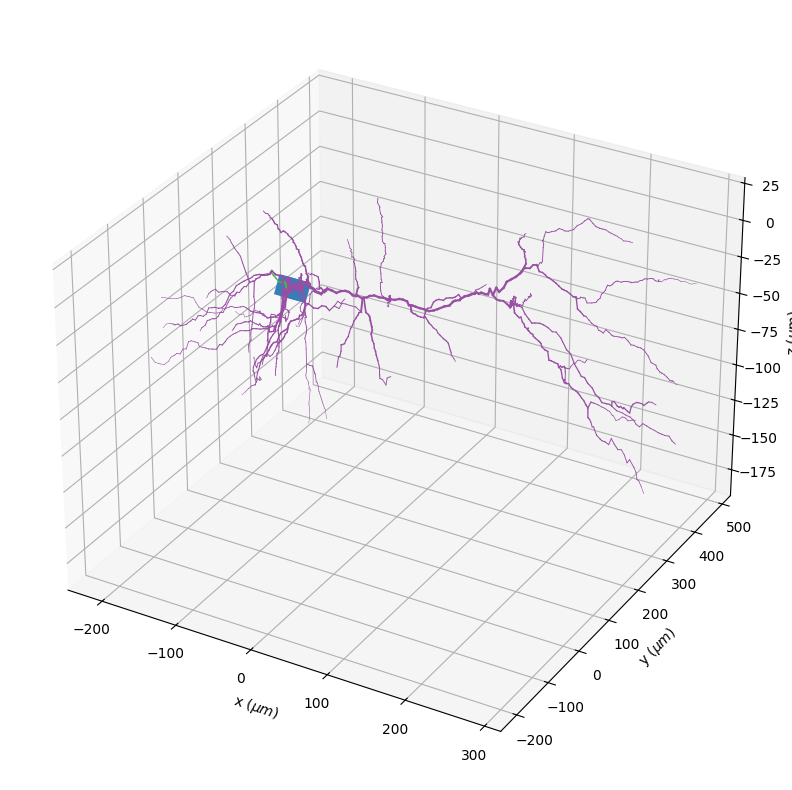

In [187]:
# SWC is a simple and common interchange format. We can load it in Arbor like this.
mrf = A.load_swc_neuron('Acker2008.swc')

fg = plt.figure(figsize=(10, 10))
fg, ax = plot_morphology(mrf, fg=fg)

Different colors denote regions of the cell that have been recorded during the segmentation process:

- soma: blue, `tag=1`
- axon: green, `tag=2`
- basal dendrite, purple `tag=3`
- apical dendrite, (not present) `tag=4`


## From Morphologies to cells

A cell, as far as we are concerned at least, comprises two main things

- a morphology
- an assignment of parameters and dynamics

So far, this is likely very familiar. However, using Arbor, we can assign different dynamics to different subsets of the cell's surface.
For efficiency reasons, neither the morphology nor the assignments are performed on the actual simulated object. Rather, we construct
descriptions towards building a simulation which then is converted to an efficient simulation. This might feel a bit weird at first, 
but is extremely important for performance.

The assignment of parameters and dynamics is handled via the `decor`

In [188]:
dec = A.decor()

As we are handling a surface, two different kinds of operations are needed: one for point-like objects and one for sub-sections of the surface.
To assign objects with a finite extent, we use

In [189]:
dec.paint('(all)', Vm = -50) # set initial membrane potential in mV

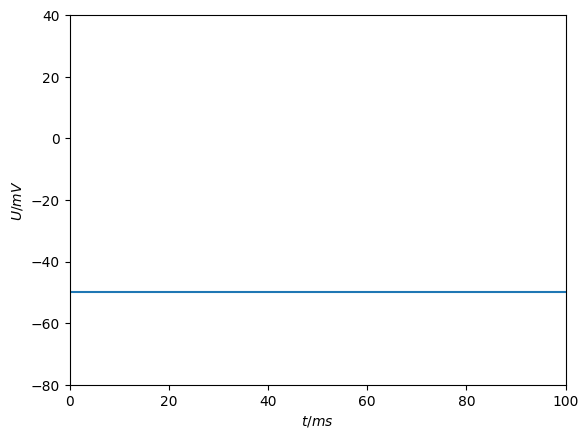

In [191]:
fg, ax = run_single_cell(mrf, dec)

Congratulations, at this point you have run your first simulation in Arbor. 
As we haven't added any dynamics, the model stays at its initial potential $-50mV$

## Adding Dynamics

Certainly the last plot felt a bit underwhelming. Let's change that by adding an ion channel. We start with the simplest possible
model, a passive current.

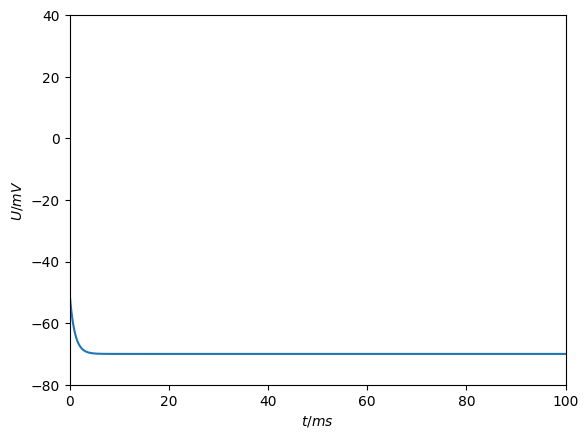

In [112]:
# we use a fresh decor here, as they are immutable objects.
dec = A.decor() 
dec.paint('(all)', Vm = -50)
# density indicates that we want an ion channel with a finite area
# the passive current is a built-in channel which we can address by
# name. For historic reasons, it's called 'pas'.
dec.paint('(all)', A.density('pas'))

run_single_cell(mrf, dec)

The passive current defined by `pas` pulls the membrane towards its (`pas`') resting potential of $-70mV$, i.e.
\begin{equation}
i_\mathrm{pas} = g\cdot (U - E_\mathrm{pas})
\end{equation}
Both $E_\mathrm{pas}$ and $g$ are parameters that can be set on the model.

Before we move on, consider the first argument to `paint`. It specifies the locations _where_ things are added. 
Without going into an overwhelming amount of detail here, Arbor use a full DSL to precisely tune the locations
to your needs. Importantly, this is independent from the simulation and the cell's discretised form.

For now, we'll use only two expressions: `(all)`, meaning all of the cell's surface and `(location 0 0.5)` 
signifying the centre of the soma.

## Adding a Stimulus

Still, nothing much is happening in our model. We need to add an external stimulus, which brings us to the second 
use of `decor`. Point-like objects are added via `place`:

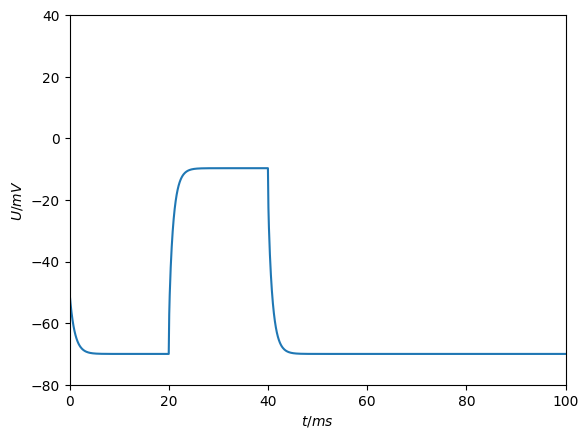

In [117]:
dec = A.decor() 
dec.paint('(all)', Vm = -50)
dec.paint('(all)', A.density('pas'))
dec.place('(location 0 0.5)', A.iclamp(tstart=20, duration=20, current=5), 'current')
run_single_cell(mrf, dec)

Note that `place` takes an extra argument; assigning a name to the placed object. For many such objects, it can be used 
to address it later.

## TASK: Extending Cell Dynamics

Now, it's on you to make something more interesting happen. Using the schematic for constructing and running a single cell model above

1. Use a more elaborate ion channel, the Hodgkin-Huxley model. Add it to the whole cell instead of the passive current.
2. Tune the stimulus to produce two action potentials
3. Add a second stimulus $t=[60, 80)$ and make one more spike

### SOLUTION

You _can_ peek here to see how we solved it, if you need help. Or ask first.

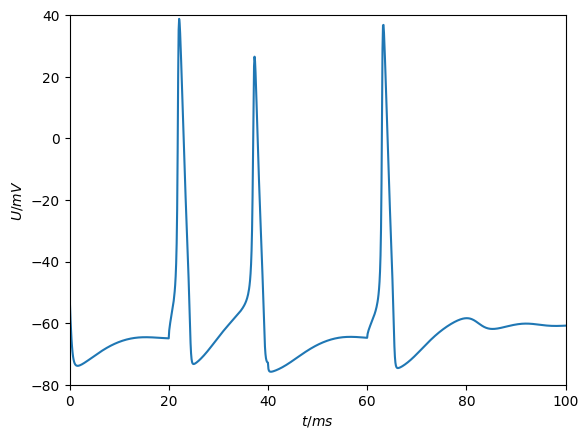

In [185]:
dec = A.decor() 
dec.paint('(all)', Vm = -50)
dec.paint('(all)', A.density('hh'))
dec.place('(location 0 0.5)', A.iclamp(tstart=20, duration=20, current=1), 'current1')
dec.place('(location 0 0.5)', A.iclamp(tstart=60, duration=80, current=0.5), 'current2')
run_single_cell(mrf, dec)

## Reflection

We have seen how to construct a single cell model and run it. 
Cells are made from morphologies and decorations, mapping parameters and dynamics onto parts of the cell. 
Dynamics can be densities or point processes. 
We have scratched the surface on how to specify locations and areas on the cell. 
There is much more to learn here, but we will leave this for another day.

# Part II: Networks

So far, we haven't shown you how simulations are actually made and run. 
Not because it's complicated or difficult, but efficiency required an API that's a bit unusual.
For building networks of cells, however, we will need to demonstrate it in full detail.

## Recreating our Single Cell Model

In Arbor, a simulation is constructed from a recipe that describes how to construct each cell and how to connect cells among each other.
To allow for trivial parallelization, this recipe is build such each cell is constructed independently from all others.
Keep this in mind while we walk you through the next bit of code and it'll make much more sense.

The central concept here is the `gid` (global identifier) that gives unique id to each cell. 
The recipe is interrogated in turn for the properties of each cell. 
We also split different properties into separate callbacks to avoid retrieving costly information more than absolutely needed.
With that preface, let's dive in.

In [155]:
# all recipes inherit from Arbor's recipe
class n_cells(A.recipe):
    def __init__(self, N):
        # initialize base class
        A.recipe.__init__(self)
        self.N = N
        # load the morphology once
        self.morph = A.load_swc_neuron('Acker2008.swc')
        
    # how many cells are in our simulation?
    # gids will be in [0, N)
    def num_cells(self):
        return self.N
    
    # what type is the cell with this gid?
    def cell_kind(self, gid):
        # here, we have homogeneous setup of purely cable cells
        return A.cell_kind.cable

    # give a description of the cell with this gid
    def cell_description(self, gid):
        # build the decor (we could make that cell-global as with the morphology)
        dec = A.decor() 
        dec.paint('(all)', Vm = -50)
        dec.paint('(all)', A.density('hh'))
        dec.place('(location 0 0.5)', A.threshold_detector(-15), 'det') # emit a spike event at -15mV
        dec.place('(location 0 0.5)', A.synapse('expsyn'),       'syn') # exponential synapse
        # result is a cable cell, **must** match the kind give above
        return A.cable_cell(self.morph, dec)

    # global properties collect information for a whole cell kind
    def global_properties(self, kind):
        assert kind == A.cell_kind.cable, f"Unexpected kind {kind}; must be cable."
        # use a standard value from the library
        return A.neuron_cable_properties()

    # a list of variables to record on cell with this gid
    def probes(self, gid):
        # membrane potential at the soma's centre
        return [A.cable_probe_membrane_voltage('(location 0 0.5)')]

Note that we also added two more items to the decor

- a threshold detector which will emit an event to all connected cells if its threshold is crossed
- a synapse to receive events. Currently though, it isn't connected to anything else.

At this point, we can run the model like this:

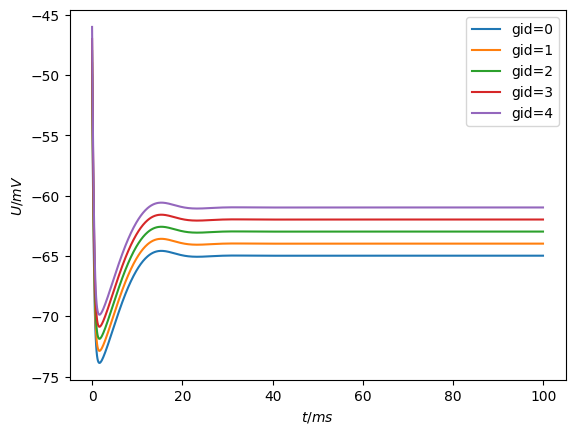

In [175]:
rec = n_cells(5)
sim = A.simulation(rec)

# probes do nothing on their own; to actually read the data, 
# we need to sample them on a schedule of time points
hdls = [sim.sample((gid, 0),                 # first probe on gid
                   A.regular_schedule(0.1))  # one time point every 0.1ms
        for gid in range(rec.num_cells())]   # for every gid

# _after_ the sampling has been been configured, we can run the 
# simulation
sim.run(100)

fg, ax = plt.subplots()

# each sample(...) gives a handle with which we can retrieve the recorded
# data
for ix, hdl in enumerate(hdls):
    samples = sim.samples(hdl)
    for data, meta in samples:
        # plot values over time (and shift by 1 mV per gid to differentiate)
        ax.plot(data[:, 0], data[:, 1] + ix, label=f'gid={ix}')
ax.set_xlabel('$t/ms$')
ax.set_ylabel('$U/mV$')
ax.legend()

Despite the evocative name, this model is not --- yet! --- a network. 
Thus the next step is to add the wiring. 
However, let's first extract the actual running of the model into a function.

In [192]:
def run_recipe(rec, T=100):
    sim = A.simulation(rec)

    hdls = [sim.sample((gid, 0),                 # first probe on gid
                       A.regular_schedule(0.1))  # one time point every 0.1ms
            for gid in range(rec.num_cells())]   # for every gid
    sim.run(T)
    
    fg, ax = plt.subplots()
    for ix, hdl in enumerate(hdls):
        samples = sim.samples(hdl)
        for data, meta in samples:
            # plot values over time (and shift by 1 mV per gid to differentiate)
            ax.plot(data[:, 0], data[:, 1] + ix, label=f'gid={ix}')
    ax.set_xlabel('$t/ms$')
    ax.set_ylabel('$U/mV$')
    ax.set_xlim(0, T)
    ax.legend()
    return fg, ax

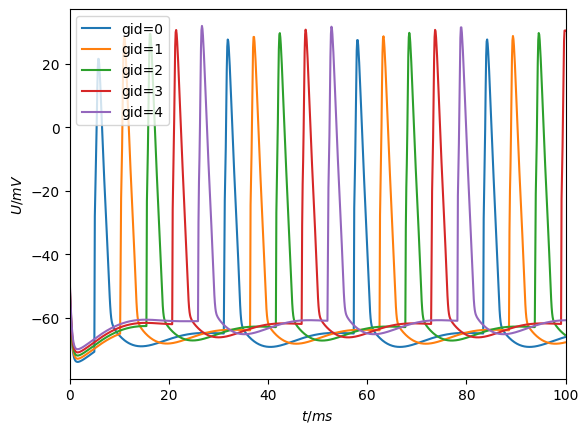

In [182]:
fg, ax = run_recipe(rec)

Yepp, still works!

Now we'll extend the recipe by good ol' fashioned object oriented programming and add some connections and an initial input

In [193]:
# ring is everything n_cells is, with some extensions
class ring(n_cells):
    def __init(self, N):
        n_cells.__init__(N)

    # connections terminating at the cell with gid
    def connections_on(self, gid):
        # connections are formed between a source, like threshold detectors,
        # and targets, like synapses. Remember, we added the detector to the
        # decor above and called it 'det'. The 'full address' of these items
        # comprises the tuple (gid, label) as there could be many detectors
        # and synapses per cell!
        return [ A.connection((0, 'det'), # source = gid, label.
                              'syn',      # target; we already know the gid from the argument
                              0.5,        # weight 
                              5,)         # delay in ms
        ]

    # event generators provide spike events as inputs to gid
    def event_generators(self, gid):
        if gid == 0:
            # event generators target a synapse with a weight and 
            # emit events on a schedule
            return [A.event_generator('syn',                     # target
                                      0.5,                       # weight
                                      A.explicit_schedule([20, 
                                                           50, 
                                                           80])) # emit at time in ms
                   ] 
        return []

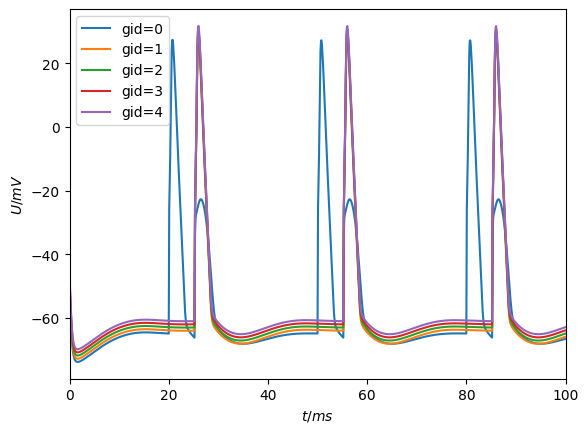

In [194]:
rec = ring(5)
fg, ax = run_recipe(rec)

Now we can see how cells interact via a network! 
The cell with `gid=0` is kickstarted by the event generator, spikes, and transmits that event to its peers.
Every cell (excluding `gid=0`) receives inputs from `gid=0` with a delay of $5ms$ and duly spikes.
The self-connection $0\leftarrow 0$ leads to another change in the membrane potential, but no spike is emitted.

## TASK: Make a proper Ring

Now, again, it is time to make your own. 
You will have noticed that despite the name, `ring` still isn't a ring, but rather a star network.
Make use of `run_recipe` and:

- make a new recipe inheriting from `n_cells`
- connect each cell to the previous (or next) `gid`
- close the ring by connecting the last to the first `gid`
- add an event generator to inject a spike
- you should be seeing a continuous series of spikes going around in the ring
- optional:
  - can you create _two_ rings that are interconnected at one or multiple points?
  - what about other topologies? fully connected? a grid? ...

### SOLUTION

Peek at your own risk!

In [180]:
class ring(n_cells):
    def __init(self, N):
        n_cells.__init__(N)

    def connections_on(self, gid):
        return [ A.connection(((gid - 1) % self.N, 'det'), # previous w/ wrap
                              'syn',
                              0.5,
                              5,)
        ]

    def event_generators(self, gid):
        if gid == 0:
            return [A.event_generator('syn',
                                      0.5,
                                      A.explicit_schedule([5]))
                   ] 
        return []

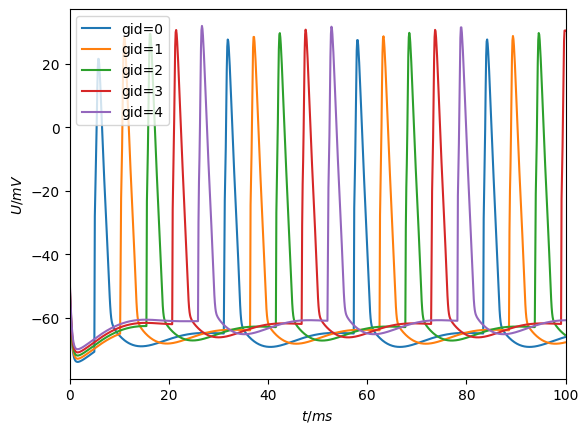

In [184]:
rec = ring(5)
fg, ax = run_recipe(rec)

## Reflection

At this point, we have demonstrated how to:

- construct a basic cell from data on disk
- endow it with dynamics
- set parameters on the cell
- how to form networks

The mental model for recipes is to answer questions from the viewpoint of the cell identified by `gid`!
These might come in-order (or not) and might be asked more than once, so take care with mutable state.